In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import corner
from VegasAfterglow import ObsData, Setups, Fitter, ParamDef, Scale

In [31]:
######### 1. PREPARE DATA #########
# Prepare your data in .csv format, following the format of example data.

# Create an instance of the ObsData class to store light curve and spectrum data
data = ObsData()

# Define the frequency bands [Hz] and corresponding light curve files
band = [2.4e17, 4.84e14, 1.4e14]
lc_files = ["data/ep.csv", "data/r.csv", "data/vt-r.csv"]

# Loop through each frequency band and corresponding file(s)
for nu, fname in zip(band, lc_files):
    # Read the light curve data from the CSV file into a pandas DataFrame
    df = pd.read_csv(fname)

    # Add the light curve data to the 'data' object for the given frequency band
    data.add_light_curve(nu_cgs=nu, t_cgs=df["t"], Fnu_cgs=df["Fv_obs"], Fnu_err=df["Fv_err"])

# Define the times [s] for spectra and corresponding files
times = [3000]
spec_files = ["data/ep-spec.csv"]    

# Loop through each time and its corresponding spectrum file
for t, fname in zip(times, spec_files):
    # Read the spectrum data from the CSV file into a pandas DataFrame
    df_spec = pd.read_csv(fname)

    # Add the spectrum data to the 'data' object for the given time
    data.add_spectrum(t_cgs=t, nu_cgs=df_spec["nu"],
                      Fnu_cgs=df_spec["Fv_obs"], Fnu_err=df_spec["Fv_err"])

######### 2. CONFIGURE MODEL #########

cfg = Setups()
cfg.lumi_dist = 3.364e28    # Luminosity distance [cm]  
cfg.z         = 1.58        # Redshift
cfg.medium    = "wind"      # Medium type: "wind", "ISM" (Interstellar Medium) or "user" (user-defined)
cfg.jet       = "powerlaw"  # Jet structure: "powerlaw", "gaussian", "tophat" or "user" (user-defined)

######### 3. DEFINE PARAMETERS #########

# Parameter name, lower bound, upper bound, scale type
# Scale.LOG means we sample log10(x), then transform via 10**v.
# Scale.LINEAR means we sample linearly
# Scale.FIXED means this param never appears in the sampler.

mc_params = [
    ParamDef("E_iso",    1e50,  1e54,  Scale.LOG),       # Isotropic energy [erg]
    ParamDef("Gamma0",      5,  1000,  Scale.LOG),       # Lorentz factor at the core
    ParamDef("theta_c",   0.0,   0.5,  Scale.LINEAR),    # Core half-opening angle [rad]
    ParamDef("theta_v",   0.0,   0.0,  Scale.FIXED),     # Viewing angle [rad]
    ParamDef("p",           2,     3,  Scale.LINEAR),    # Power law index
    ParamDef("eps_e",    1e-2,   0.5,  Scale.LOG),       # Electron energy fraction
    ParamDef("eps_B",    1e-4,   0.5,  Scale.LOG),       # Magnetic field energy fraction
    ParamDef("A_star",   1e-3,     1,  Scale.LOG),       # Star formation rate normalization
    #ParamDef("n_ism",   1e-3,    10,  Scale.LOG),       # Number density of medium [cm^-3]
    ParamDef("xi",       1e-3,     1,  Scale.LOG),       # Efficiency factor
]

######### 4. RUN MCMC #########
# Create an instance of the MCMC Fitter class using the prepared data and configuration
fitter = Fitter(data, cfg)

# Run the fitting process using the defined parameters for specified number of MCMC steps (total_steps)
result = fitter.fit(
    mc_params,
    resolution=(0.4, 1, 5),#resolution of the grid, the optimal resolution is data dependent, you may change it based on your data
    total_steps=10000,
    burn_frac=0.3,
    top_k=10
)

# Create a table for top-k parameters
top_k_data = []
for i in range(result.top_k_params.shape[0]):
    row = {'Rank': i+1, 'chi^2': f"{-2*result.top_k_log_probs[i]:.2f}"}
    for name, val in zip(result.labels, result.top_k_params[i]):
        row[name] = f"{val:.4f}"
    top_k_data.append(row)

top_k_df = pd.DataFrame(top_k_data)
print("Top-k parameters:")
print(top_k_df.to_string(index=False))

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:26<00:00, 376.59it/s]

Top-k parameters:
 Rank chi^2   E_iso Gamma0 theta_c      p   eps_e   eps_B  A_star      xi
    1 15.76 52.6574 1.3187  0.3466 2.5019 -1.4503 -1.1510 -2.1924 -1.8893
    2 15.95 52.4088 1.2457  0.2711 2.4901 -1.1911 -1.3138 -2.1340 -1.7401
    3 16.04 52.4461 1.2564  0.2649 2.4870 -1.2347 -1.3004 -2.1337 -1.7700
    4 16.17 52.3442 1.2311  0.4188 2.4862 -1.1505 -1.4035 -2.1187 -1.7336
    5 16.19 52.9531 1.5132  0.3034 2.4724 -1.8204 -0.5078 -2.6046 -2.0240
    6 16.20 52.7675 1.1551  0.2867 2.4674 -1.5380 -2.1792 -1.3855 -2.2230
    7 16.26 52.6176 1.1057  0.3344 2.4950 -1.3547 -2.2473 -1.3859 -2.1064
    8 16.37 52.4230 1.2668  0.3233 2.5200 -1.1979 -1.2360 -2.2453 -1.7102
    9 16.37 52.8220 1.3773  0.2948 2.4939 -1.6360 -1.0257 -2.2529 -2.0221
   10 16.39 52.4012 1.3694  0.4531 2.5261 -1.2082 -0.5412 -2.6601 -1.5599


In [28]:
# Define time and frequency ranges for predictions
t_out = np.logspace(2, 9, 150)

nu_out = np.logspace(16,20,150)

best_params = result.top_k_params[8]

# Generate model light curves at the specified bands using the best-fit parameters
lc = fitter.light_curves(best_params, t_out, band)

# Generate model spectra at the specified times using the best-fit parameters
spec = fitter.spectra(best_params, nu_out, times)

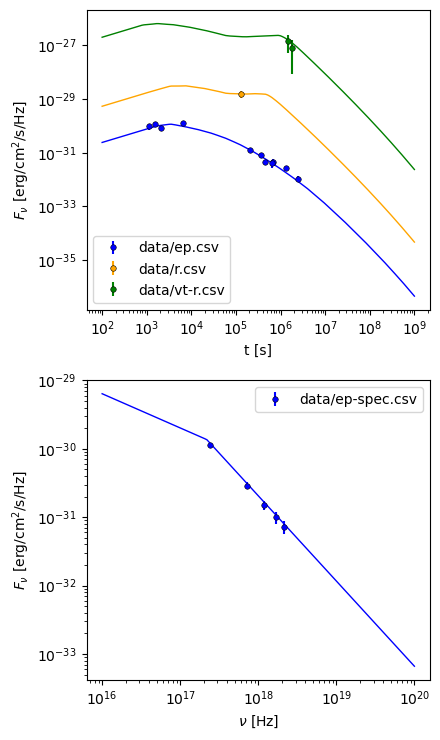

In [29]:
# Function to plot model light curves along with observed data
def draw_bestfit(t,lc_fit, nu, spec_fit):
    lc_files = ["data/ep.csv", "data/r.csv", "data/vt-r.csv"]
    spec_files = ["data/ep-spec.csv"]
    nus = [2.4e17, 4.84e14, 1.4e14]
    ts = [3000]

    fig =plt.figure(figsize=(4.5, 7.5))

    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)

    shift = [1,1,200]
    colors = ['blue', 'orange', 'green']
    for i, file, sft, c in zip(range(len(lc_files)), lc_files, shift, colors ):
        df = pd.read_csv(file)
        ax1.errorbar(df["t"], df["Fv_obs"]*sft, df["Fv_err"]*sft, fmt='o',markersize=4,label=file, color=c,markeredgecolor='k', markeredgewidth=.4)
        ax1.plot(t, np.array(lc_fit[i])*sft, color=c,lw=1)

    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('t [s]')
    ax1.set_ylabel(r'$F_\nu$ [erg/cm$^2$/s/Hz]')
    ax1.legend()
  
    for i, file, sft, c in zip(range(len(spec_files)), spec_files, shift, colors ):
        df = pd.read_csv(file)
        ax2.errorbar(df["nu"], df["Fv_obs"]*sft, df["Fv_err"]*sft, fmt='o',markersize=4,label=file, color=c,markeredgecolor='k', markeredgewidth=.4)
        ax2.plot(nu, np.array(spec_fit[i])*sft, color=c,lw=1)

    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel(r'$\nu$ [Hz]')
    ax2.set_ylabel(r'$F_\nu$ [erg/cm$^2$/s/Hz]')
    ax2.legend()
    plt.tight_layout()

draw_bestfit(t_out, lc, nu_out, spec)
   

📊 Corner plot saved to: corner_plot_g.png


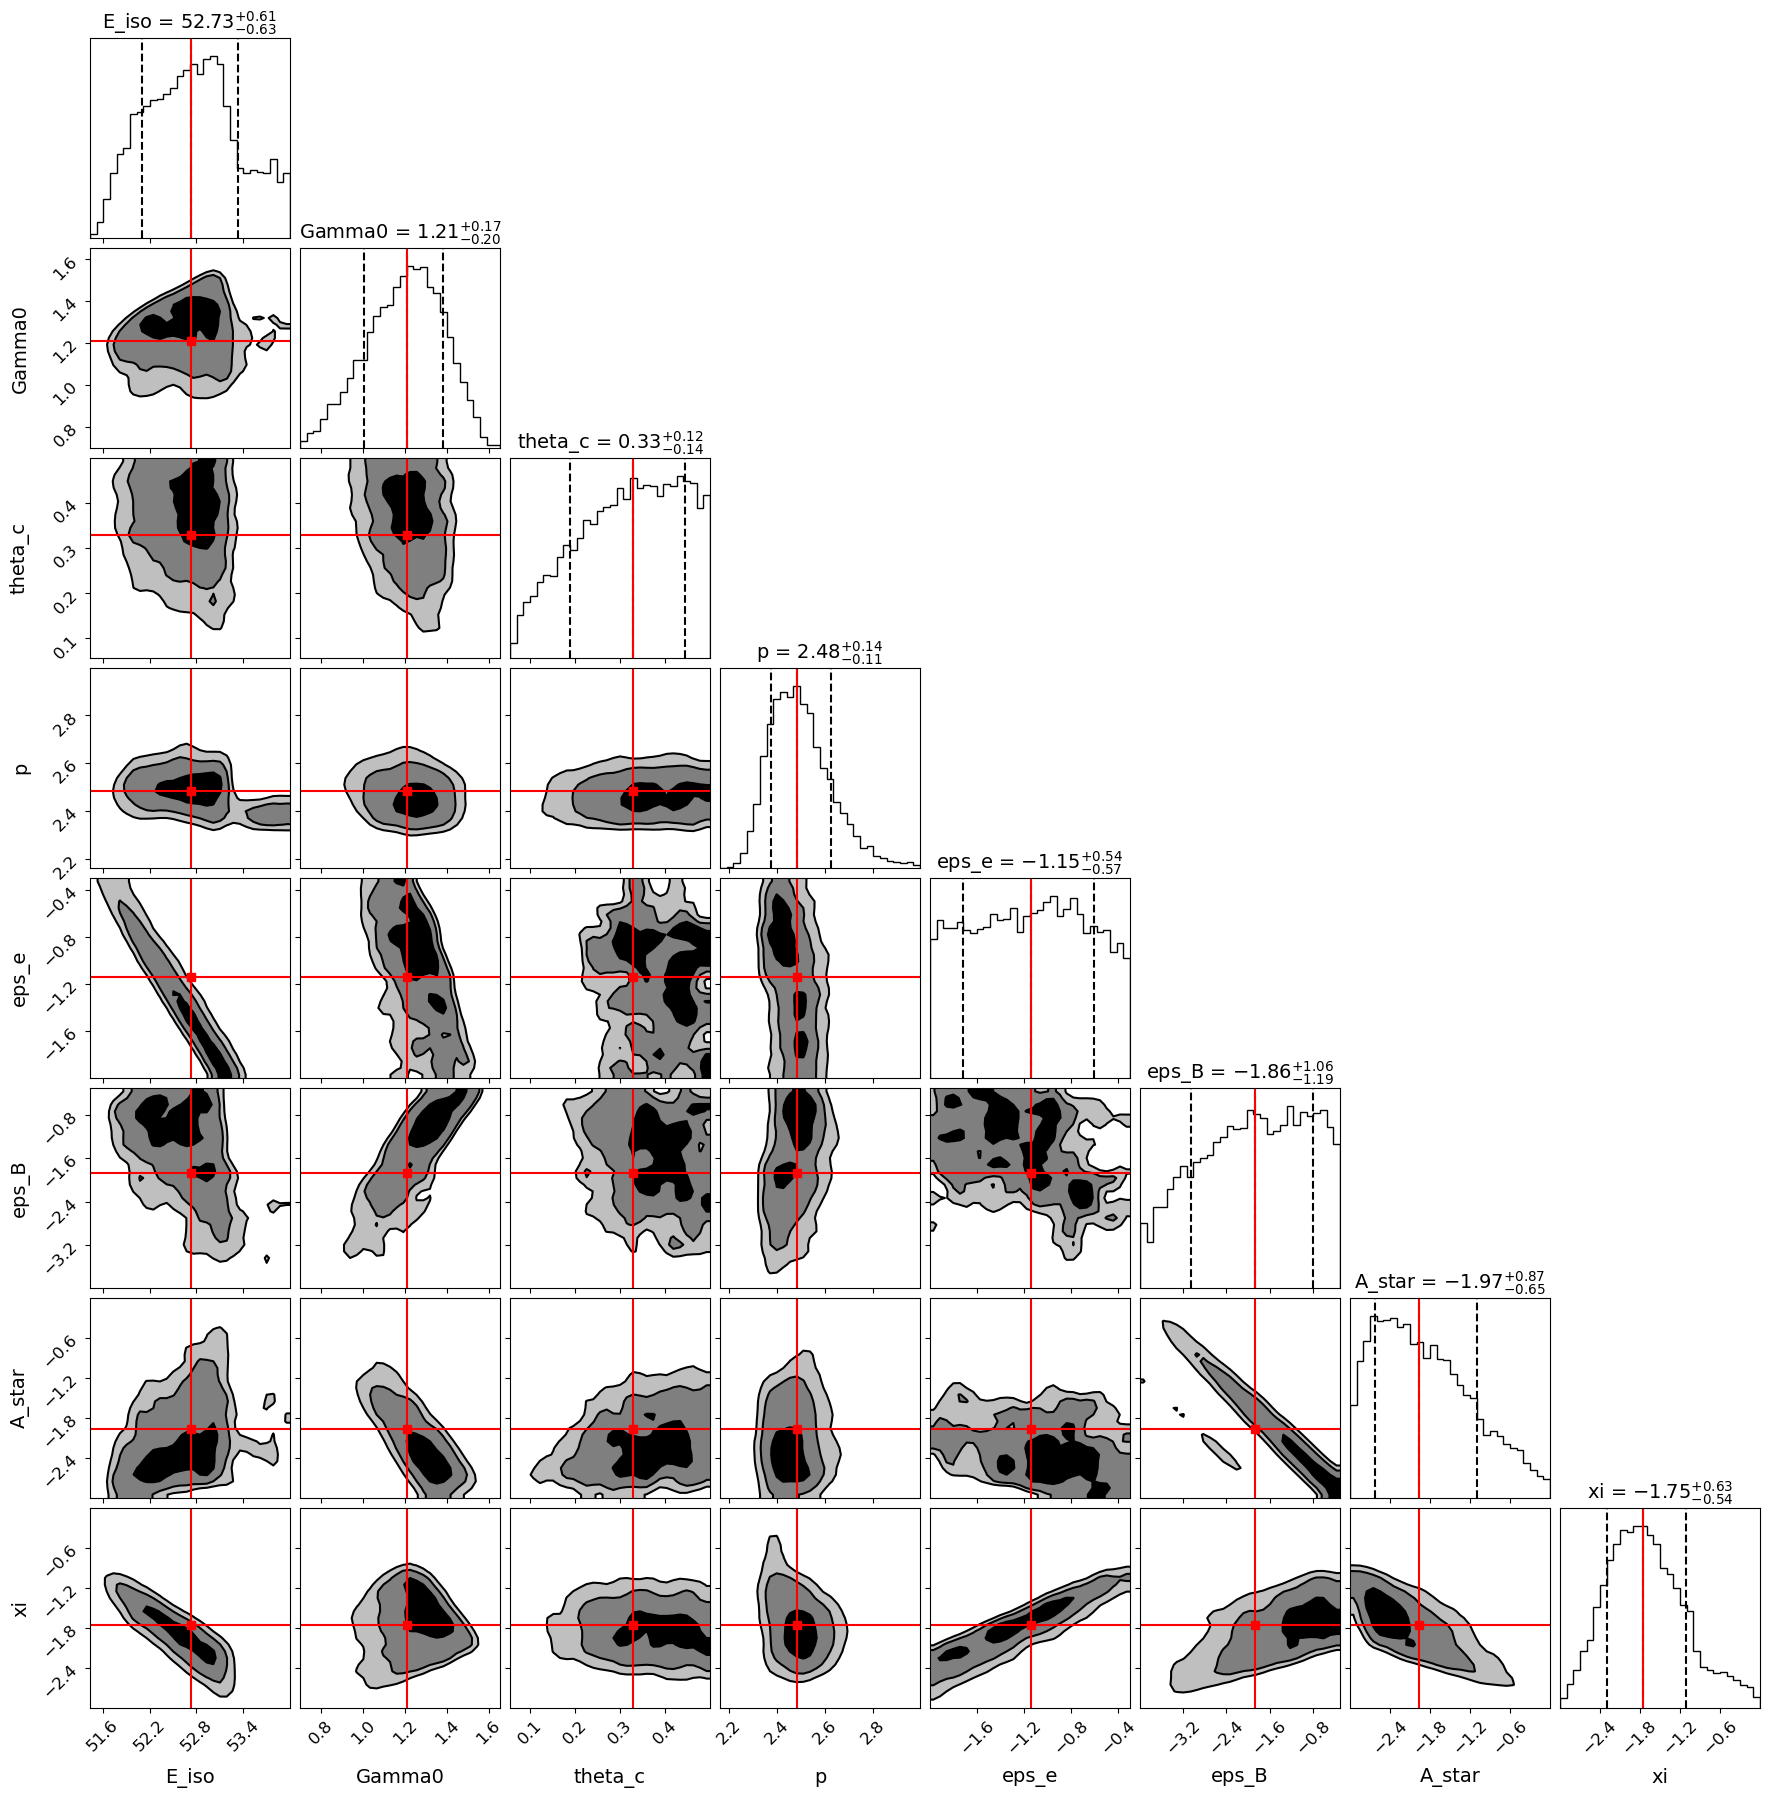

In [30]:
# Function to create a corner plot showing parameter correlations and confidence intervals
def plot_corner(flat_chain, labels, filename="corner_plot.png"):
    fig = corner.corner(
        flat_chain,
        labels=labels,
        quantiles=[0.16, 0.5, 0.84],  # For median and ±1σ
        show_titles=True,
        title_kwargs={"fontsize": 14},
        label_kwargs={"fontsize": 14},
        #range=ranges,  # Optional: constrain plot ranges
        truths=np.median(flat_chain, axis=0),  # Show median values
        truth_color='red',
        smooth=1,
        bins=30,  # Number of bins in histograms
        plot_datapoints=False,
        fill_contours=True,
        levels=[0.16, 0.5, 0.68],  # 1σ and 2σ contours
        color='k',
        alpha=0.5
    )
    for ax in fig.get_axes():
        ax.tick_params(axis='both', labelsize=12) 
    fig.savefig(filename, dpi=600, bbox_inches='tight')
    print(f"📊 Corner plot saved to: {filename}")

# Function to make a trace plot to show MCMC convergence over steps
def plot_trace(chain, labels, filename="trace_plot.png"):
    nsteps, nwalkers, ndim = chain.shape
    fig, axes = plt.subplots(ndim, figsize=(10, 2.5 * ndim), sharex=True)

    for i in range(ndim):
        for j in range(nwalkers):
            axes[i].plot(chain[:, j, i], alpha=1,lw=0.5)
        axes[i].set_ylabel(labels[i])
        axes[i].grid(True)
    
    axes[-1].set_xlabel("Step")
    plt.tight_layout()
    plt.savefig(filename, dpi=600, bbox_inches='tight')
    print(f"📉 Trace plot saved to: {filename}")

#data = np.load("mcmc_results54-refine.npz")
#chain = data["chain"]
#labels = data["labels"]

#plot_trace(result.samples, result.labels, filename="trace_plot.png")

flat_chain = result.samples.reshape(-1, result.samples.shape[-1])

plot_corner(flat_chain, result.labels, filename="corner_plot_g.png")